In [1]:
import csv
import pandas as pd
import numpy as np
import math
import re
import os
import string
from sklearn import metrics
import xgboost as xgbf
import statsmodels.api as sm
import numpy as np
import got3
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
from sklearn.model_selection import RandomizedSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cross_validation import train_test_split
from sklearn.metrics import classification_report
from sklearn.linear_model import LinearRegression, Lasso, LassoCV           
from sklearn.model_selection import StratifiedShuffleSplit    
import statsmodels.formula.api as smf
from sklearn.cross_validation import cross_val_score
import time
from gensim.models import AuthorTopicModel
from importlib import reload
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score,  fbeta_score, roc_auc_score, matthews_corrcoef

import nltk
from nltk.probability import FreqDist
from nltk.stem.wordnet import WordNetLemmatizer



import xgboost as xgb

from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import cross_val_score

from sklearn.model_selection import StratifiedKFold


%matplotlib inline
pd.options.display.max_colwidth = 100


/home/louis/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
/home/louis/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
import site
site.getsitepackages()


['/home/louis/anaconda3/lib/python3.6/site-packages']

In [ ]:
#ssh -i "aws_key.pem" ubuntu@ec2-54-148-44-124.us-west-2.compute.amazonaws.com


## 1. Data Prep - direct tweets

In [5]:
import pymongo
client = pymongo.MongoClient("mongodb://louis: @ec2-54-148-44-124.us-west-2.compute.amazonaws.com/twitter") # defaults to port 27017
db = client.twitter
collection = db ['twitter_direct']

In [6]:
df_d_tweets = pd.DataFrame(list(collection.find()))

In [7]:
df_d_tweets.shape

(918, 11)

In [1621]:
punctuation

['!',
 '"',
 '#',
 '$',
 '%',
 '&',
 "'",
 '(',
 ')',
 '*',
 '+',
 ',',
 '-',
 '.',
 '/',
 ':',
 ';',
 '<',
 '=',
 '>',
 '?',
 '@',
 '[',
 '\\',
 ']',
 '^',
 '_',
 '`',
 '{',
 '|',
 '}',
 '~']

### Pre-Process Tweets 

In [11]:
import preprocessor as p
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
import re, string
import nltk

punctuation = list(string.punctuation)

stopwords_lst = stopwords.words('english') + punctuation + \
                ['rt', 'via', 'RT', '…', '–' , '‘', '’', '“', '”'] + \
                [str(x) for x in range(0,10)] + \
                ['added', 'favorited', 'liked']
    
                
        
english_vocab = set(w.lower() for w in nltk.corpus.words.words())
    
    
def process_tweet_text(tweet, clean = True):

    if clean:
        tweet = p.clean(tweet)
    
    tweet = re.sub(r'['+string.punctuation+']+', ' ',tweet) # Remove puncutations like 's
   
    tweet = tweet.lower()
    
    named_things = ['reilly bodycomb', 
                    'top rock',
                    'leg lock',
                    'leg attack',
                    'knee bar', 
                    'ankle lock',
                    'achilles lock',
                    'heel hook', 
                    'toe hold', 
                    'arm bar', 
                    'rear naked choke', 
                    'full guard', 
                    'half guard', 
                    'no gi'
                    'no kurtka', 
                    'leg reap',
                    'back step'
                    'guard pass',
                    'no gi', 
                    'combat sambo',
                    'sport sambo',
                    'sambo wrestling,'
                    'submission only',
                    'submission grappling',
                    'brazilian j',
                    'jiu jit',
                    'ju jit',
                    'mixed martial arts',
                    'mixed marital arts']

    for i in named_things:
        condensed_name = i.replace(' ','')
        tweet = tweet.replace(i, condensed_name)
        tweet = tweet.replace(condensed_name+'s', condensed_name)

    named_variations = {'top rock 2: turbo': 'toprock', 
                        'top rock 2': 'toprock', 
                        'top rock turbo': 'toprock',
                        'achilleslock': 'anklelock',
                        'leglock': 'leglock',
                        'leglocking' : 'leglock',
                        'legattack ': 'leglock',
                        'jujitsu': 'jiujitsu',
                        'jujitu': 'bjj',
                        'jiujitu': 'bjj',
                        'brazilian jiu-jitsu': 'bjj',
                        'brazilianjiujitsu': 'bjj',
                        'jiujitsu': 'bjj',
                        'sportsambo': 'sambo',
                        'sambowrestling': 'sambo',
                        'reillybodycomb': 'reilly',
                        'rdojo': 'reilly',
                        'r-dojo': 'reilly',
                        'mixedmartialarts': 'mma',
                        'mixedmaritalarts': 'mma'}

    for i, j in named_variations.items():
        tweet = tweet.replace(i, j)
        
    
        
    tweet = re.sub(r'\$\w*','',tweet) # Remove tickers
    #tweet = re.sub(r'https?:\/\/.*\/\w*','',tweet) # Remove hyperlinks
    
    twtok = TweetTokenizer(strip_handles=True, reduce_len=True)
    tokens = twtok.tokenize(tweet)
    #print(tokens)
    tokens = [i.lower() for i in tokens if i not in stopwords_lst]
 
    tokens = ['bjj' if 'bjj' in i  else i for i in tokens]

    lmtzr = WordNetLemmatizer()
    # Lemmatize article by running each word through the pattern.en lemmatizer and only including it in the resulting text if the word doesn't appear in the set of stopwords
    tokens = [lmtzr.lemmatize(w) for w in tokens]
    
    return ' '.join(tokens)
    #return tokens



In [13]:
process_tweet_text('Top Rock by Reilly Bodycomb - Budovideos Inc.')

'toprock reilly budovideos inc'

In [14]:
df_d_tweets['text'] = df_d_tweets['text'].str.strip()

In [15]:
df_d_tweets['processed'] = df_d_tweets['text'].apply(process_tweet_text)

In [16]:
df_d_tweets['processed_hashtags'] = df_d_tweets['hashtags'].apply(lambda x: process_tweet_text(x, clean=False))

In [17]:
# Remove infrequent words 
twtok = TweetTokenizer(strip_handles=True, reduce_len=True)    
all_tokens = pd.DataFrame(twtok.tokenize(' '.join(df_d_tweets['processed'])), columns = ['tokens'])
token_cts = all_tokens['tokens'].value_counts(ascending = True) 
token_cts[token_cts  <= 3]

stopwords_lst = stopwords_lst + token_cts[token_cts  <= 3].index.tolist()


In [18]:
df_d_tweets['processed'] = df_d_tweets['processed'].apply(process_tweet_text)

In [19]:
print(df_d_tweets.loc[1, 'text'])
df_d_tweets.loc[1, 'processed']

#grappling #bjj #jujitsu #mma #mixedmaritalarts Reilly Bodycomb – ‘ Mastering Ankle Locks’ Download http://ow.ly/vWE550gCFZK


'reilly anklelock download'

## 2. Exploratory Data Analysis

### Look at hashtags
#### - insight into potential topics

In [20]:
df_d_tweets[['hashtags', 'processed_hashtags']].head()

,hashtags,processed_hashtags
0,#guywithnoinstagram #sambo #jiujitsupic,guywithnoinstagram sambo bjj
1,#grappling #bjj #jujitsu #mma #mixedmaritalarts,grappling bjj bjj mma mma
2,,
3,#sambo #jiujitsu #leglocksbeforetheywerecool,sambo bjj leglockbeforetheywerecool
4,,


In [ ]:
def author_barplot(author_name, n_topic = 10, save = ''):
    sns.set_style("white")
    with plt.rc_context({'nbagg.transparent':'True', 'axes.labelcolor': 'white', 'text.color':'white', 'axes.edgecolor':'white', 'xtick.color':'white', 'ytick.color':'white', 'figure.facecolor':'white'}):
        fig = plt.figure(figsize=(12,6))
        fig.patch.set_alpha(0.5)
        df_at = pd.DataFrame([(topic_labels[topic[0]], topic[1]) for topic in model[author_name]], columns = ['Topics', 'Dist'])
        df_at.sort_values('Dist', ascending =False)

        sns_plot = sns.barplot(df_at['Topics'][:(n_topic)], df_at['Dist'][:(n_topic)], \
                    palette= sns.color_palette("husl", 10), ci=None)
        plt.title("Twitter Profile: " + author_name, fontsize = 16 )
        plt.ylabel('Density', fontsize = 16)
        plt.xlabel('Topic', fontsize = 16)
        plt.xticks(rotation=45, fontsize = 12)

        if save != '':
            fig = sns_plot.get_figure()
            fig.savefig(save +'.png', transparent=True)
    

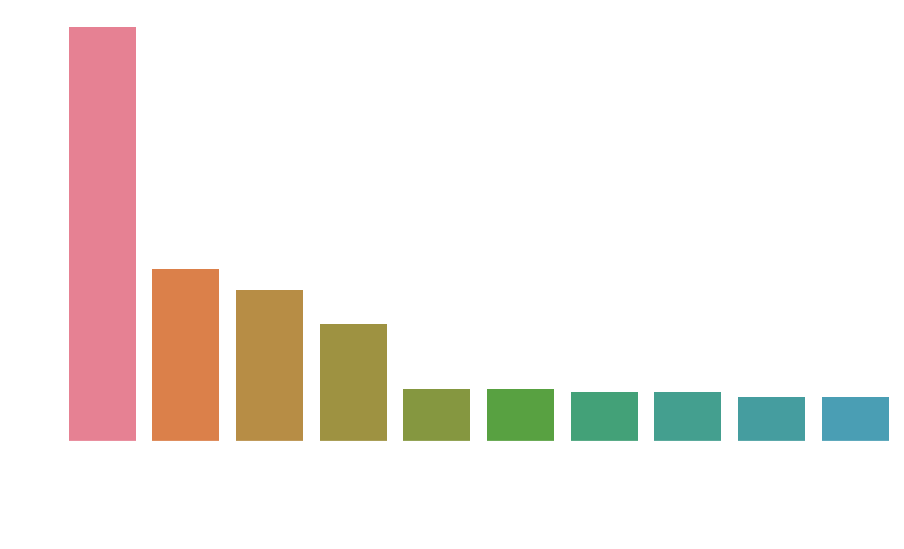

In [41]:
hashtags = []
for hs in df_d_tweets["processed_hashtags"]: # Each entry may contain multiple hashtags. Split.
    if hs != '':
        hashtags += hs.split(" ")
fdist1 = FreqDist(['#'+x for x in hashtags])


tags = pd.DataFrame(hashtags)
tags_cts = tags[0].value_counts().iloc[0:10]
tags_cts.index = '#' + tags_cts.index

sns.set_style("white")
with plt.rc_context({'nbagg.transparent':'True', 'axes.labelcolor': 'white', 'text.color':'white', 'axes.edgecolor':'white', 'xtick.color':'white', 'ytick.color':'white', 'figure.facecolor':'white'}):

    plt.figure(figsize = (15,8))
    sns_plot = sns.barplot(x=tags_cts.index, y=tags_cts, palette= sns.color_palette("husl", 15)) #, color = "steelblue")
    plt.xticks(rotation=45)
    plt.tick_params(axis='both', which='major', labelsize=14)#, fontsize = 20)
    plt.xlabel('Hashtags', fontsize = 20)
    plt.ylabel('Counts', fontsize = 20)
 #   plt.title('Hashtag Histogram', fontsize = 26)

    fig = sns_plot.get_figure()
    fig.savefig('direct_hashtags' +'.png', transparent=True)

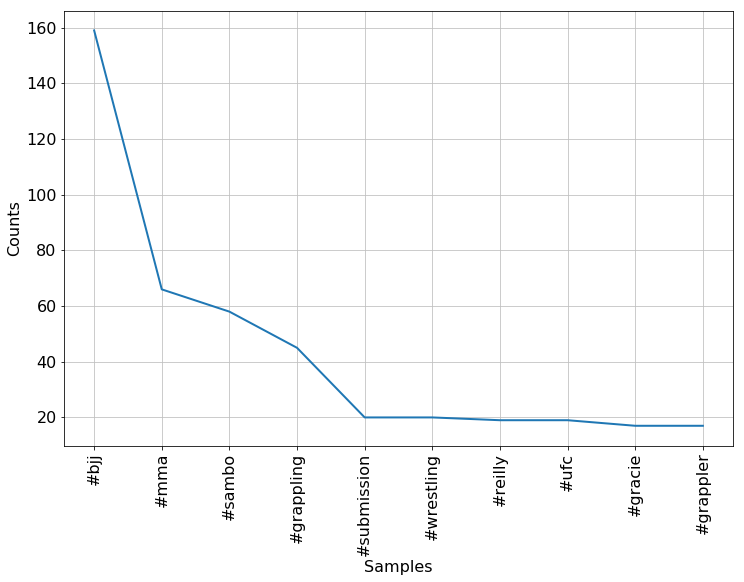

In [1556]:

plt.figure(figsize = (12,8))
#plt.xticks(rotation=45)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.xlabel('Hashtags', fontsize =16)
plt.ylabel('Counts', fontsize =16)
#plt.title("HashTags")
fdist1.plot(10)
#plt.xlabel(fontsize = 14)

### Reduction

In [43]:
# Imports
# Basics
from __future__ import print_function, division
import pandas as pd 
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
# gensim
from gensim import corpora, models, similarities, matutils
# sklearn
from sklearn import datasets
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
import sklearn.metrics.pairwise as smp

from sklearn.decomposition import NMF

import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

#### TFIDF Creation

In [44]:
# Vectorize the text using TFIDF
# also drop duplicate tweets/retweets

df_du_tweets = df_d_tweets
df_du_tweets['text'] = df_du_tweets['text'].apply(p.clean)
df_du_tweets.drop_duplicates('text', keep='last', inplace=True)
df_du_tweets.reset_index(inplace=True)


tfidf = TfidfVectorizer(stop_words="english", 
                        token_pattern="\\b[a-zA-Z][a-zA-Z]+\\b", #words with >= 2 alpha chars 
                        min_df=10)
tfidf_vecs = tfidf.fit_transform(df_du_tweets['processed'])
pd.DataFrame(tfidf_vecs.todense(), 
             columns=tfidf.get_feature_names()
            ).head()

,anklelock,arch,awesome,bay,bjj,bloody,book,brutality,camp,carry,...,tournament,training,usa,victor,video,week,weekend,world,wrestling,youtube
0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.976777,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.412125,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.834660,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [45]:
# Convert sparse matrix of counts to a gensim corpus
# Need to transpose it for gensim which wants 
# terms by docs instead of docs by terms
tfidf_corpus = matutils.Sparse2Corpus(tfidf_vecs.transpose())

# Row indices
id2word = dict((v, k) for k, v in tfidf.vocabulary_.items())

# This is a hack for Python 3!
id2word = corpora.Dictionary.from_corpus(tfidf_corpus, 
                                         id2word=id2word)



2018-03-08 12:34:49,211 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2018-03-08 12:34:49,216 : INFO : built Dictionary(101 unique tokens: ['training', 'reilly', 'anklelock', 'coach', 'leglock']...) from 798 documents (total 1397 corpus positions)


In [128]:
# plot silhoutte function
import matplotlib.cm as cm

def plot_sil(n_clusters, tfidf_vecs):

#    n_clusters = kclust_sil

    #.figure(figsize = (14,10))


    ax1 = plt.figure(figsize = (14,10)).gca()
    #fig.set_size_inches(20, 10)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([0, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    #ax1.set_ylim([0, tfidf_vecs.shape[0] + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict( tfidf_vecs )

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(tfidf_vecs, cluster_labels)


    sample_silhouette_values = silhouette_samples(tfidf_vecs, cluster_labels)


    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                        0, ith_cluster_silhouette_values,
                        facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhoutte score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])


    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers


    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                "with n_clusters = %d" % n_clusters),
               fontsize=14, fontweight='bold')

    plt.show()

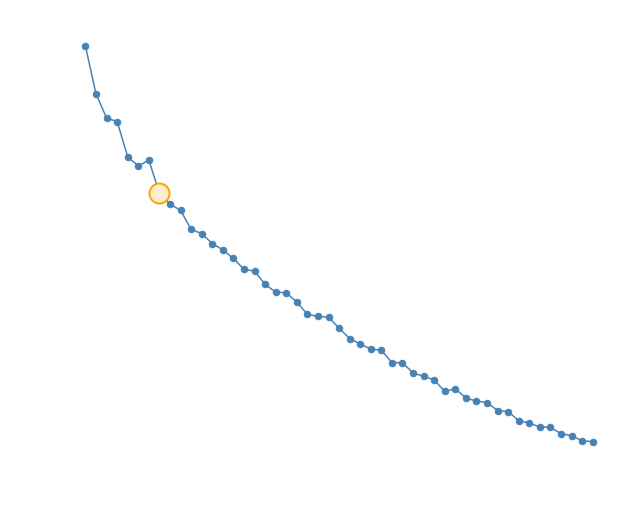

In [72]:
#Elbow Plot

sns.set_style("white")
with plt.rc_context({'nbagg.transparent':'True', 'axes.labelcolor': 'white', 'text.color':'white', 'axes.edgecolor':'white', 'xtick.color':'white', 'ytick.color':'white', 'figure.facecolor':'white'}):

    plt.figure(figsize = (10,8))
    plt.plot(clusters_rng, pd.DataFrame(best_inertias).mean(), ".-", color = 'steelblue', markersize = 13)
    plt.plot(clusters_rng[kclust_elbow], pd.DataFrame(best_inertias).mean()[kclust_elbow], marker='o', markersize=20, color = 'blanchedalmond',
             markeredgewidth=2, markeredgecolor='orange')#, markerfacecolor=None)
    plt.ylabel("Inertia", fontsize = 16)
    plt.xlabel("K Clusters", fontsize = 16)
    plt.xticks(fontsize = 16)
    plt.yticks(fontsize = 16)
    plt.title("Kmeans Elbow Plot", fontsize = 18)
#    plt.show()


#    fig = plt_plot.get_figure()
    plt.savefig('direct_elbow' +'.png', transparent=True)

#         plt.title("Twitter Profile: " + author_name, fontsize = 16 )
#         plt.ylabel('Density', fontsize = 16)
#         plt.xlabel('Topic', fontsize = 16)
#         plt.xticks(rotation=45, fontsize = 12)

        
        
        

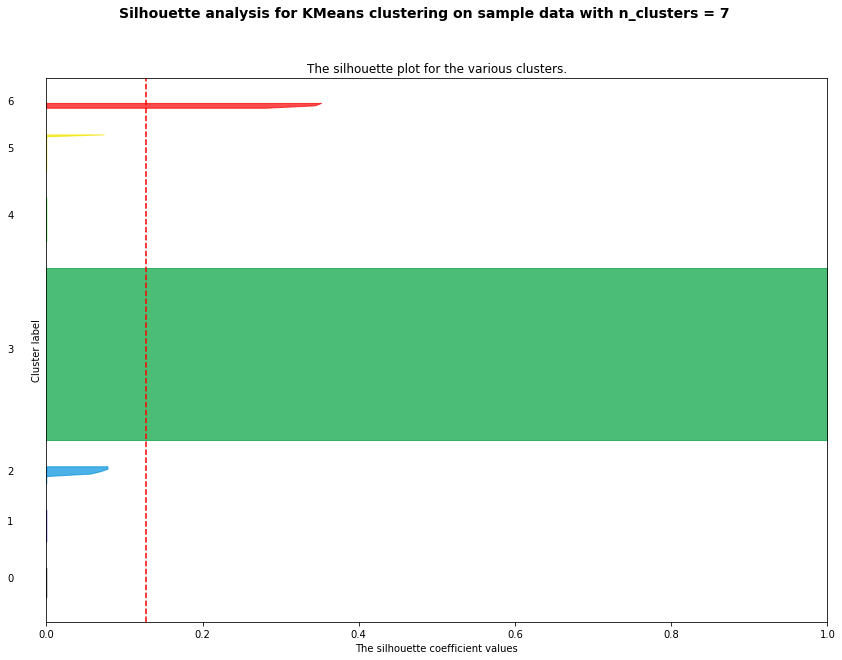

In [1611]:
#plot silhouette. N_Cluster based on elbow.
plot_sil(kclust_elbow, tfidf_vecs)

### a. LSI Model

In [154]:
# 10, 100 to start to see
# reran with modified arguments after analyzing elbow, etc

NUM_TOPICS = 50
NUM_FEATURES = 50

In [155]:
lsi = models.LsiModel(tfidf_corpus, id2word=id2word, num_topics=NUM_TOPICS)

2018-03-08 13:21:22,864 : INFO : using serial LSI version on this node
2018-03-08 13:21:22,865 : INFO : updating model with new documents
2018-03-08 13:21:22,895 : INFO : preparing a new chunk of documents
2018-03-08 13:21:22,899 : INFO : using 100 extra samples and 2 power iterations
2018-03-08 13:21:22,900 : INFO : 1st phase: constructing (101, 150) action matrix
2018-03-08 13:21:22,908 : INFO : orthonormalizing (101, 150) action matrix
2018-03-08 13:21:22,919 : INFO : 2nd phase: running dense svd on (101, 798) matrix
2018-03-08 13:21:22,925 : INFO : computing the final decomposition
2018-03-08 13:21:22,926 : INFO : keeping 50 factors (discarding 17.962% of energy spectrum)
2018-03-08 13:21:22,927 : INFO : processed documents up to #798
2018-03-08 13:21:22,928 : INFO : topic #0(10.131): 0.925*"reilly" + 0.217*"sambo" + 0.159*"seminar" + 0.121*"leglock" + 0.076*"video" + 0.072*"grappling" + 0.063*"nogi" + 0.057*"bjj" + 0.049*"highlight" + 0.047*"today"
2018-03-08 13:21:22,929 : INFO :

In [114]:
NUM_FEATURES

50

In [117]:
# Retrieve vectors for the original tfidf corpus in the LSI space ("transform" in sklearn)
lsi_corpus = lsi[tfidf_corpus]

# Dump the resulting document vectors into a list so we can take a look
doc_vecs = [doc for doc in lsi_corpus]

# Create an index transformer that calculates similarity based on 
# our space
index = similarities.MatrixSimilarity(doc_vecs, 
                                      num_features=NUM_FEATURES)


2018-03-08 13:05:57,979 : INFO : creating matrix with 798 documents and 50 features


In [118]:
print("LSI Topics")
print("")
 
for idx in range(NUM_TOPICS):
    # Print the first 10 most representative topics
    print("Topic #%s:" % idx, lsi.print_topic(idx, 5))
 

LSI Topics

Topic #0: 0.925*"reilly" + 0.217*"sambo" + 0.159*"seminar" + 0.121*"leglock" + 0.076*"video"
Topic #1: -0.691*"sambo" + 0.348*"reilly" + -0.327*"leglock" + -0.246*"nogi" + -0.245*"grappling"
Topic #2: -0.781*"seminar" + 0.200*"sambo" + 0.192*"technique" + 0.191*"talk" + 0.191*"make"
Topic #3: -0.382*"seminar" + -0.352*"make" + -0.348*"talk" + -0.332*"technique" + -0.326*"palhares"
Topic #4: 0.705*"leglock" + -0.397*"sambo" + 0.251*"grappling" + 0.233*"nogi" + -0.163*"seminar"
Topic #5: -0.518*"grappling" + 0.373*"leglock" + -0.371*"highlight" + -0.330*"nogi" + 0.322*"video"
Topic #6: -0.612*"video" + 0.294*"leglock" + -0.282*"heelhook" + -0.218*"scissor" + -0.207*"flying"
Topic #7: -0.586*"bjj" + -0.427*"camp" + -0.306*"training" + -0.299*"today" + -0.232*"great"
Topic #8: 0.561*"bjj" + -0.526*"camp" + -0.374*"training" + -0.199*"great" + 0.185*"bay"
Topic #9: -0.536*"heelhook" + 0.318*"video" + -0.298*"eddie" + -0.286*"cummings" + -0.245*"bloody"
Topic #10: 0.448*"combatsa

In [119]:
ng_lsi = matutils.corpus2dense(lsi_corpus, num_terms=51).transpose()
print(ng_lsi.shape)


(798, 51)


In [123]:
#select topic
# 7 is heel hooks, ankle locks
topic_idx = 5

# Return the sorted list of cosine similarities to the first document
sims = sorted(enumerate(index[doc_vecs[topic_idx]]), key=lambda item: -item[1])

print('Selected Topic: #', topic_idx)
# Let's take a look at how we did
for sim_doc_id, sim_score in sims[0:15]: 
    print("Score: " + str(sim_score)[:4], '::', df_du_tweets.loc[sim_doc_id]['text'][:90])
    #print("")
#    print(df_d_tweets.loc[sim_doc_id][['user', 'text']])
#    print(df_d_tweets.loc[sim_doc_id]['user'], " ::: ", df_d_tweets.loc[sim_doc_id]['dt'], " ::: ", df_d_tweets.loc[sim_doc_id]['processed'], df_d_tweets.loc[sim_doc_id]['id'])
#    print(, df_d_tweets.loc[sim_doc_id]['id'])

Selected Topic: # 5
Score: 1.0 :: years to when I was lucky enough to teach at one of my coach's clubs in . was a trooper of
Score: 0.94 :: - When I gave my first , given to me by my coach, to rdojo as he prepared to…
Score: 0.63 :: Coach Reilly , Julisa .jules, and Moises drilling the shot with these new recruits. .
Score: 0.61 :: but I've done a few Reilly Bodycomb seminars and really liked his style, more into coaches
Score: 0.57 :: Reilly Bodycomb on Instagram: “ wrecking it with another style inverted...
Score: 0.56 :: thank you1please check out coach of Reilly Bodycomb als ( )
Score: 0.55 :: alright so the last two weeks I've been working on an article with Sambo coach Reilly Body
Score: 0.54 :: Congrats to my Sambo coach and Reilly Bodycomb, who both won their divisions at the Arnold
Score: 0.53 :: of my coaches is Reilly Bodycomb, the leg lock guy & Hall's training partner. Curiously en
Score: 0.52 :: Bay Jiu-Jitsu coaches. Thanks for coming out to ref and score! .
Score: 0.43 

In [120]:
ng_lsi

array([[ 0.02840641,  0.00614622, -0.01936784, ..., -0.04232841,
        -0.03350408,  0.        ],
       [ 0.22202535,  0.07025682, -0.05880848, ...,  0.02569558,
        -0.08038595,  0.        ],
       [ 0.24541904, -0.04075007,  0.00267595, ..., -0.11254986,
         0.2658927 ,  0.        ],
       ...,
       [ 0.16341597, -0.00907798, -0.13763429, ...,  0.0256051 ,
        -0.10126266,  0.        ],
       [ 0.40504774, -0.2014607 ,  0.02552521, ...,  0.05901916,
         0.01077783,  0.        ],
       [ 0.40404633,  0.13515642,  0.03129947, ..., -0.17806077,
         0.03567502,  0.        ]], dtype=float32)

In [122]:
#Find number of clusters
from collections import Counter
from sklearn.metrics import silhouette_samples, silhouette_score


elbow_kinks = []
best_sils = []
best_inertias = []

for i in range(0,1):
    print(i)
    MAX_K = 49

    clusters_rng = range(1, MAX_K + 1)

    inertias = np.zeros(MAX_K)
    diff = np.zeros(MAX_K)
    diff2 = np.zeros(MAX_K)
    diff3 = np.zeros(MAX_K)
    sil_scores = []

    for k in clusters_rng:
        kmeans = KMeans(k, init='k-means++',  n_init=7, random_state = 0 ).fit(ng_lsi)
        labels = kmeans.predict(ng_lsi)
        
        if k == 1:
            sil_scores.append(-1)
        else:
            sil_scores.append(silhouette_score(tfidf_vecs, labels))
        
        inertias[k - 1] = kmeans.inertia_
        # first difference    
        if k > 1:
            diff[k - 1] = inertias[k - 1] - inertias[k - 2]
        # second difference
        if k > 2:
            diff2[k - 1] = diff[k - 1] - diff[k - 2]
        # third difference
        if k > 3:
            diff3[k - 1] = diff2[k - 1] - diff2[k - 2]

    elbow_kinks.append(np.argmin(diff3[3:]) + 3)
    best_sils.append(np.argmax(sil_scores))
    best_inertias.append(inertias)

kclust_elbow = Counter(elbow_kinks).most_common(1)[0][0]
kclust_sil = Counter(best_sils).most_common(1)[0][0]



0


In [125]:
kclust_elbow

3

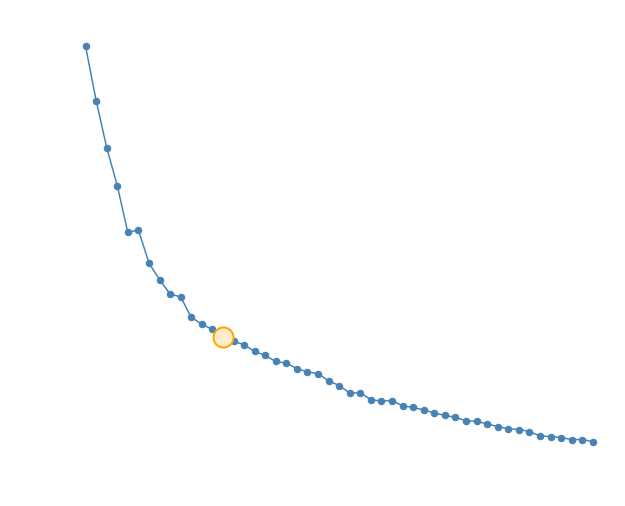

In [190]:
#Elbow Plot

sns.set_style("white")
with plt.rc_context({'nbagg.transparent':'True', 'axes.labelcolor': 'white', 'text.color':'white', 'axes.edgecolor':'white', 'xtick.color':'white', 'ytick.color':'white', 'figure.facecolor':'white'}):

    plt.figure(figsize = (10,8))
    plt.plot(clusters_rng, pd.DataFrame(best_inertias).mean(), ".-", color = 'steelblue', markersize = 13)
    plt.plot(clusters_rng[13], pd.DataFrame(best_inertias).mean()[13], marker='o', markersize=20, color = 'blanchedalmond',
             markeredgewidth=2, markeredgecolor='orange')#, markerfacecolor=None)
    plt.ylabel("Inertia", fontsize = 16)
    plt.xlabel("K Clusters", fontsize = 16)
    plt.xticks(fontsize = 16)
    plt.yticks(fontsize = 16)
    plt.title("Kmeans Elbow Plot", fontsize = 18)
#    plt.show()


#    fig = plt_plot.get_figure()
    plt.savefig('direct_elbow' +'.png', transparent=True)

#         plt.title("Twitter Profile: " + author_name, fontsize = 16 )
#         plt.ylabel('Density', fontsize = 16)
#         plt.xlabel('Topic', fontsize = 16)
#         plt.xticks(rotation=45, fontsize = 12)

        
        
        

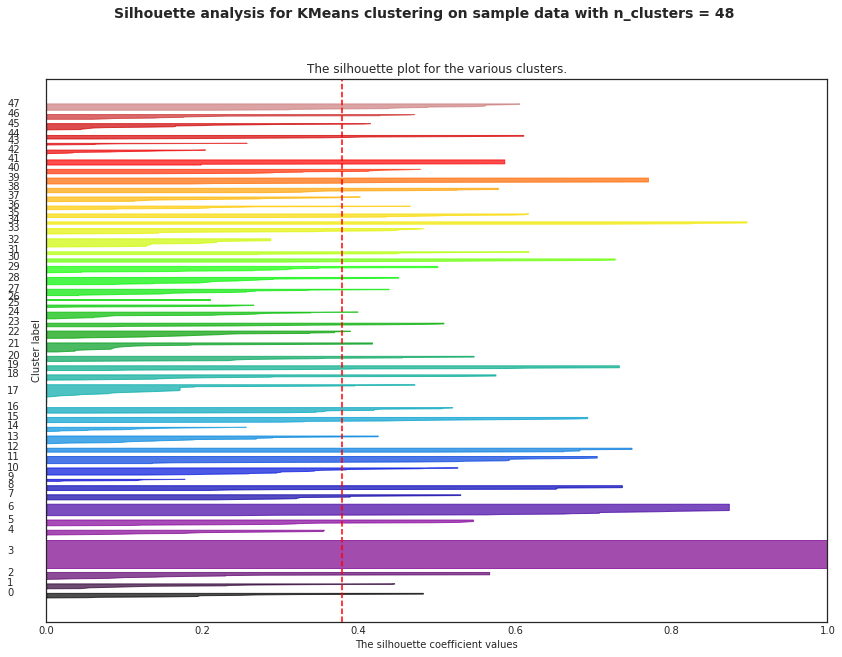

In [130]:
#plot silhouette. N_Cluster based on silhoutte score
plot_sil(kclust_sil, ng_lsi)

#### Explore specific topics and similarities

In [135]:
kmeans = KMeans(13, init='k-means++',  n_init=7, random_state = 0 ).fit(ng_lsi)
labels = kmeans.predict(ng_lsi)

In [151]:
df_d_tweets[[labels == 8][0]].sample(frac=1).head(20)['text']

376    So Reilly Bodycomb having a good day. Published an article and announced he is taking on Eddie C...
283                  Eddie Cummings beats Reilly Bodycomb rdojo by submission. Both of these warriors are…
279                                                          Eddie Cummings vs Reilly Bodycomb Polaris Pro
9                   Reilly Bodycomb - Flying Scissor Leg Takedown Details ( Fake Kick into body scissor) …
619       He añadido un vídeo a una lista de reproducción de ( - Reilly Bodycomb - Flying Scissor Takedown
618                                      I liked a video Reilly Bodycomb - Flying Scissor Takedown Details
89                                                       Awesome Scissor Takedown and Kneebar from rdojo …
340                                                                       Scissor take down drill. rdojo …
347                                                       Reilly Bodycomb: Sambo Flying Scissor to Kneebar
202                  rdojo with repos

### b. LDA Model

In [1577]:
lda_model = models.LdaModel(corpus=tfidf_corpus, num_topics=NUM_TOPICS, id2word=id2word)

2018-03-05 01:34:17,923 : INFO : using symmetric alpha at 0.06666666666666667
2018-03-05 01:34:17,924 : INFO : using symmetric eta at 0.06666666666666667
2018-03-05 01:34:17,924 : INFO : using serial LDA version on this node
2018-03-05 01:34:17,943 : INFO : running online (single-pass) LDA training, 15 topics, 1 passes over the supplied corpus of 798 documents, updating model once every 798 documents, evaluating perplexity every 798 documents, iterating 50x with a convergence threshold of 0.001000
2018-03-05 01:34:17,944 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2018-03-05 01:34:18,549 : INFO : -8.401 per-word bound, 338.0 perplexity estimate based on a held-out corpus of 798 documents with 1397 words
2018-03-05 01:34:18,549 : INFO : PROGRESS: pass 0, at document #798/798
2018-03-05 01:34:19,038 : INFO : topic #3 (0.067): 0.063*"present" + 0.062*"reilly" + 0.054*"check" + 0.039*"day" + 0.036*"tra

In [1578]:
print("LDA Topics")
print("")
 
for idx in range(NUM_TOPICS):
    # Print the first 10 most representative topics
    print("Topic #%s:" % idx, lda_model.print_topic(idx, 5))
 

LDA Topics

Topic #0: 0.073*"reilly" + 0.068*"highlight" + 0.041*"th" + 0.039*"interview" + 0.033*"heelhook"
Topic #1: 0.142*"reilly" + 0.123*"seminar" + 0.042*"video" + 0.030*"new" + 0.030*"ny"
Topic #2: 0.136*"reilly" + 0.088*"sambo" + 0.045*"leglock" + 0.042*"bjj" + 0.037*"control"
Topic #3: 0.063*"present" + 0.062*"reilly" + 0.054*"check" + 0.039*"day" + 0.036*"training"
Topic #4: 0.266*"reilly" + 0.064*"sambo" + 0.037*"ryan" + 0.032*"seminar" + 0.029*"hall"
Topic #5: 0.076*"reilly" + 0.071*"sambo" + 0.068*"leglock" + 0.065*"video" + 0.053*"nogi"
Topic #6: 0.062*"reilly" + 0.062*"grappling" + 0.053*"bjj" + 0.051*"eddie" + 0.041*"cummings"
Topic #7: 0.219*"reilly" + 0.080*"sambo" + 0.052*"leglock" + 0.038*"nogi" + 0.029*"highlight"
Topic #8: 0.073*"reilly" + 0.042*"book" + 0.038*"sambo" + 0.037*"seminar" + 0.035*"check"
Topic #9: 0.091*"heelhook" + 0.073*"reilly" + 0.059*"video" + 0.052*"toprock" + 0.041*"mike"
Topic #10: 0.081*"reilly" + 0.062*"sambo" + 0.057*"seminar" + 0.052*"new

In [1579]:
# Retrieve vectors for the original tfidf corpus in the LSI space ("transform" in sklearn)
lda_corpus = lda_model[tfidf_corpus]

# Dump the resulting document vectors into a list so we can take a look
doc_vecs = [doc for doc in lda_corpus]

# Create an index transformer that calculates similarity based on 
# our space
index = similarities.MatrixSimilarity(doc_vecs, 
                                      num_features=NUM_FEATURES)


2018-03-05 01:34:19,588 : INFO : creating matrix with 798 documents and 100 features


In [1580]:
#select topic
# 3 tourney talk
topic_idx = 7

# Return the sorted list of cosine similarities to the first document
sims = sorted(enumerate(index[doc_vecs[topic_idx]]), key=lambda item: -item[1])

print('Selected Topic: #', topic_idx)
# Let's take a look at how we did
for sim_doc_id, sim_score in sims[0:15]: 
    print("Score: " + str(sim_score)[:4], '::', df_du_tweets.loc[sim_doc_id]['text'][:90])
    #print("")
#    print(df_d_tweets.loc[sim_doc_id][['user', 'text']])
#    print(df_d_tweets.loc[sim_doc_id]['user'], " ::: ", df_d_tweets.loc[sim_doc_id]['dt'], " ::: ", df_d_tweets.loc[sim_doc_id]['processed'], df_d_tweets.loc[sim_doc_id]['id'])
#    print(, df_d_tweets.loc[sim_doc_id]['id'])

Selected Topic: # 7
Score: 1.0 :: 我顶了一个 视频 Reilly Bodycomb Seminar at Studio : Ankle lock to Heel Hook Transition
Score: 1.0 :: Reilly Bodycomb Seminar at Studio : Ankle lock to Heel Hook Transition …
Score: 0.99 :: … Reilly Bodycomb Seminar at Studio : Ankle lock to Heel Hook Transition .
Score: 0.96 :: Friday night drilling the Reilly Bodycomb heel hook setups from leg drag
Score: 0.95 :: Question about the straight ankle lock in Reilly Bodycomb's "Top Rock"
Score: 0.93 :: Reilly Bodycomb – ‘ Mastering Ankle Locks’ Download
Score: 0.93 :: Reilly Bodycomb's tripoding ankle lock. I've learned this from him and have had a quite a 
Score: 0.93 :: Tonight's seminar with Reilly bodycomb
Score: 0.93 :: Thank you to Reilly Bodycomb for his seminar tonight! Really enjoyed it! Thank you to Nels
Score: 0.93 :: Went to Reilly Bodycomb’s Saturday seminar on attacking and defending Achilles locks, and 
Score: 0.93 :: Jag lade till ett videoklipp i en spellista på Reilly Bodycomb Seminar at Studio 

### c. NMF Model

In [159]:
from sklearn.decomposition import NMF
nmf = NMF(n_components=100)
nmf_vecs = nmf.fit_transform(tfidf_vecs)

In [161]:
# KMeans clustering on Newsgroups
# Use the data loaded from earlier
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=13)
kmeans.fit(nmf_vecs)
#kmeans.fit_predict(nmf_vecs)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=13, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [162]:
TOPIC_INDEX = 12

In [163]:
## word cloud
from os import path
import matplotlib.pyplot as plt
from wordcloud import WordCloud

def terms_to_wordcounts(terms, multiplier=1000):
    return  " ".join([" ".join(int(multiplier*i[0]) * [i[1]]) for i in terms])


In [164]:
kmeans.fit_predict(nmf_vecs).shape

(798,)

In [181]:
TOPIC_INDEX = 1
samp_topic = df_du_tweets.loc[kmeans.predict(nmf_vecs) == TOPIC_INDEX]
samp_topic['text']

56                              Victor Roll! Can't wait for the Tournament tomorrow at am at Bay Jiu-Jitsu
159             Awesome! Congratulations rdojo on the gold! It was the roll with tcthundercat that really…
192                                                               Victor Roll Leg Locks -Reilly Bodycomb …
370    I added a video to a playlist 'Victor Roll' counter to a body lock- Reilly Bodycomb Seminar - NY...
490                           'Victor Roll' counter to a body lock- Reilly Bodycomb Seminar - NY July ...:
491                I liked a video 'Victor Roll' counter to a body lock- Reilly Bodycomb Seminar - NY July
492                            'Victor Roll' counter to a body lock- Reilly Bodycomb Seminar - NY July ...
631                              I liked a video Sambo Technique: Victor Roll Leg Locks by Reilly Bodycomb
715                          I favorited a video Sambo Technique: Victor Roll Leg Locks by Reilly Bodycomb
758                                Mm

In [ ]:
kmeans.predict(nmf_vecs) 

In [1535]:
df_du_tweets['text'][df_du_tweets['text'].str.contains('BJJ')]

11     Don't forget this weekend Precision will have Sambo Eert and BJJ Black Belt Reilly Bodycomb in f...
12     's Reilly Bodycomb is on the latest episode of the Great Northeast BJJ Podcast. Come for the sam...
60                                             Reilly Bodycomb: Translating his no gi techniques to gi BJJ
62                             I liked a video Reilly Bodycomb: Translating his no gi techniques to gi BJJ
64                                                 Sambo Technique in BJJ tournament Reilly Bodycomb :// …
67                     Panda Nation grappler Reilly Bodycomb earned his BJJ black belt over the weekend! .
68                                              Congrats to Reilly Bodycomb on getting his BJJ black belt!
113    So American Sambo stand out Reilly Bodycomb did an IBJJF Open for the first time and finished se...
189                                           TBT To RDojo Sambo Camp In House Tournament Finals at GSBJJ!
214                                  

In [183]:
#Find number of clusters
from collections import Counter
from sklearn.metrics import silhouette_samples, silhouette_score


elbow_kinks = []
best_sils = []
best_inertias = []

for i in range(0,1):
    print(i)
    MAX_K = 49

    clusters_rng = range(1, MAX_K + 1)

    inertias = np.zeros(MAX_K)
    diff = np.zeros(MAX_K)
    diff2 = np.zeros(MAX_K)
    diff3 = np.zeros(MAX_K)
    sil_scores = []

    for k in clusters_rng:
        kmeans = KMeans(k, init='k-means++',  n_init=7, random_state = 0 ).fit(nmf_vecs)
        labels = kmeans.predict(nmf_vecs)
        
        if k == 1:
            sil_scores.append(-1)
        else:
            sil_scores.append(silhouette_score(tfidf_vecs, labels))
        
        inertias[k - 1] = kmeans.inertia_
        # first difference    
        if k > 1:
            diff[k - 1] = inertias[k - 1] - inertias[k - 2]
        # second difference
        if k > 2:
            diff2[k - 1] = diff[k - 1] - diff[k - 2]
        # third difference
        if k > 3:
            diff3[k - 1] = diff2[k - 1] - diff2[k - 2]

    elbow_kinks.append(np.argmin(diff3[3:]) + 3)
    best_sils.append(np.argmax(sil_scores))
    best_inertias.append(inertias)

kclust_elbow = Counter(elbow_kinks).most_common(1)[0][0]
kclust_sil = Counter(best_sils).most_common(1)[0][0]



0


In [186]:
kclust_sil

47

In [188]:
kclust_elbow

6

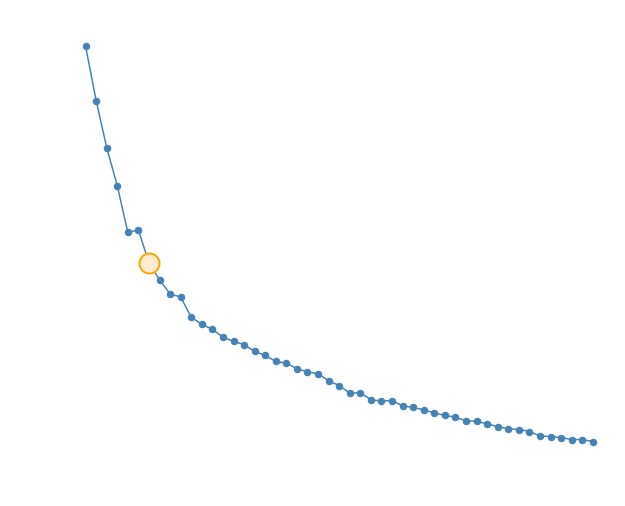

In [189]:
#Elbow Plot

sns.set_style("white")
with plt.rc_context({'nbagg.transparent':'True', 'axes.labelcolor': 'white', 'text.color':'white', 'axes.edgecolor':'white', 'xtick.color':'white', 'ytick.color':'white', 'figure.facecolor':'white'}):

    plt.figure(figsize = (10,8))
    plt.plot(clusters_rng, pd.DataFrame(best_inertias).mean(), ".-", color = 'steelblue', markersize = 13)
    plt.plot(clusters_rng[kclust_elbow], pd.DataFrame(best_inertias).mean()[kclust_elbow], marker='o', markersize=20, color = 'blanchedalmond',
             markeredgewidth=2, markeredgecolor='orange')#, markerfacecolor=None)
    plt.ylabel("Inertia", fontsize = 16)
    plt.xlabel("K Clusters", fontsize = 16)
    plt.xticks(fontsize = 16)
    plt.yticks(fontsize = 16)
    plt.title("Kmeans Elbow Plot", fontsize = 18)
#    plt.show()


#    fig = plt_plot.get_figure()
    plt.savefig('direct_elbow' +'.png', transparent=True)

#         plt.title("Twitter Profile: " + author_name, fontsize = 16 )
#         plt.ylabel('Density', fontsize = 16)
#         plt.xlabel('Topic', fontsize = 16)
#         plt.xticks(rotation=45, fontsize = 12)

        
        
        

                                                                                                    text
414         Technique Talk: Reilly Bodycomb makes sense of Rousimar Palhares' brutality … via GOOD shit!
416             MUST SEE!! Technique Talk: Reilly Bodycomb makes sense of Rousimar Palhares' brutality …
419  This is OUTSTANDING!! Technique Talk: Reilly Bodycomb, makes sense of Rousimar Palhares' brutali...
420                       Technique Talk: Reilly Bodycomb makes sense of Rousimar Palhares' brutality...
421                        Technique Talk: Reilly Bodycomb makes sense of Rousimar Palhares' brutality |
422                  Technique Talk: Reilly Bodycomb makes sense of Rousimar Palhares' brutality … by on
424           Post Edited: Technique Talk: Reilly Bodycomb makes sense of Rousimar Palhares' brutality …
425           Technique Talk: Reilly Bodycomb makes sense of Rousimar Palhares' brutality – MMA Fighting
426         Technique Talk: Reilly Bodycomb makes sense

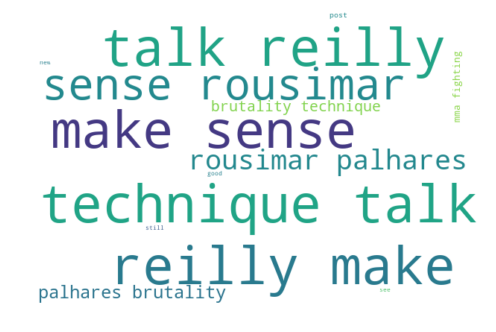

0


In [1530]:
#wordcloud = WordCloud(width=1000, height=500, regexp=r"\w[\w' ]+").generate("+".join(my_list))
#TOPIC_INDEX = 0
samp_topic = df_du_tweets.loc[kmeans.predict(nmf_vecs) == TOPIC_INDEX]
prev = samp_topic[[ 'text']]
#print(prev)
wordcloud = WordCloud(width=600, height=400, background_color='white', max_words=25).generate(text = ' '.join(samp_topic['processed']))
print(prev.head(15))
#plt.axis("off")
#plt.savefig("terms1")
print(prev.shape)

plt.figure(figsize = (8,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()
#plt.close()

print(TOPIC_INDEX)
#0 palhares
#1 random
#2 sambo seminar
#3 leglock seminar
#4 combat sambo
#5 random
#6 *low
#7 seminar review *low
#8 nogi grappling
#9 sambo samboleague
#10 sambo vid
#11 ny sambo
#12 specific palhares *low
#13 interview *low
#14 seminar norm? 

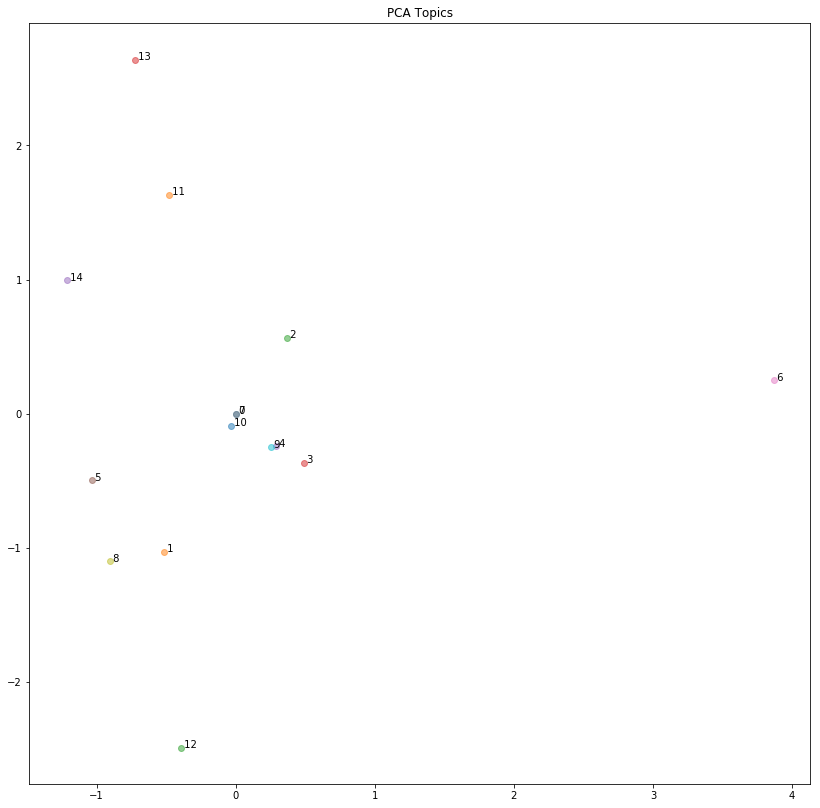

In [1620]:
from sklearn.feature_extraction import DictVectorizer

lda = lda_model
n_topics = 15
def topics_to_vectorspace(n_topics, n_words=20):
    rows = []
    for i in range(n_topics):
        temp = lda.show_topic(i, n_words)
        row = dict(((i[1],i[0]) for i in temp))
        rows.append(row)

    return rows    

vec = DictVectorizer()
X = vec.fit_transform(topics_to_vectorspace(n_topics))


from sklearn.decomposition import PCA

pca = PCA(n_components=2)

X_pca = pca.fit(X.toarray()).transform(X.toarray())

plt.figure(figsize = (14,14))
for i in range(X_pca.shape[0]):
    plt.scatter(X_pca[i, 0], X_pca[i, 1], alpha=.5)
    plt.text(X_pca[i, 0], X_pca[i, 1], s=' ' + str(i))    

plt.title('PCA Topics')
plt.savefig("pca_topic")

plt.show()



In [1585]:
pca.singular_values_

array([9.99099711, 9.92657537])